# From Dense Layers to Convolutions

The models that we've discussed so far are fine options
if you're dealing with *tabular* data.
By *tabular* we mean that the data consists
of rows corresponding to examples and columns corresponding to features.
With tabular data, we might anticipate that pattern we seek
could require modeling interactions among the features,
but do not assume anything a priori about
which features are related to each other or in what way.


Sometimes we truly may not have any knowledge
to guide the construction of more cleverly-organized architectures.
and in these cases, a multilayer perceptron is often the best that we can do.
However, once we start dealing with high-dimensional perceptual data,
these *structure-less* networks can grow unwieldy.


For instance, let's return to our running example
of distinguishing cats from dogs.
Say that we do a thorough job in data collection,
collecting an annotated sets of high-quality 1-megapixel photographs.
This means that the input into a network has *1 million dimensions*.
Even an aggressive reduction to *1,000 hidden dimensions*
would require a *dense* (fully-connected) layer to support $10^9$ parameters.
Unless we have an extremely large dataset (perhaps billions?),
lots of GPUs, a talent for extreme distributed optimization,
and an extraordinary amount of patience,
learning the parameters of this network may turn out to be impossible.

A careful reader might object to this argument
on the basis that 1 megapixel resolution may not be necessary.
However, while you could get away with 100,000 pixels,
we grossly underestimated the number of hidden nodes
that it typically takes to learn good hidden representations of images.
Learning a binary classifier with so many parameters
might seem to require that we collect an enormous dataset,
perhaps comparable to the number of dogs and cats on the planet.
And yet Yet both humans and computers are able to distinguish cats from dogs quite well, seemingly contradicting these conclusions.
That's because images exhibit rich structure
that is typically exploited by humans and machine learning models alike.

## Invariances

Imagine that you want to detect an object in an image.
It seems reasonable that whatever method we use to recognize objects
should not be overly concerned with the precise *location*
of the object shouldn't in the image.
Ideally we could learn a system
that would somehow exploit this knowledge.
Pigs usually don't fly and planes usually don't swim.
Nonetheless, we could still recognize a flying pig were one to appear.
This ideas is taken to an extreme in the children's game 'Where's Waldo', an
example is shown in the image below.
The game consists of a number of chaotic scenes bursting with activity
and Waldo shows up somewhere in each
(typically lurking in some unlikely location).
The reader's goal is to locate him.
Despite his characteristic outfit, this can be surprisingly difficult,
due to the large number  of confounders.

Back to images, the intuitions we have been discussion could be made more concrete yielding a few key principles for building neural networks for computer vision:

1. Our vision systems should, in some sense, respond similarly to the same object regardless of where it appears in the image (Translation Invariance)
1. Our visions systems should, in some sense, focus on local regions, without regard for what else is happening in the image at greater distances. (Locality)

Let's see how this translates into mathematics.

## Constraining the MLP

<!-- In this exposition, we treat both images and hidden layers
alike as two-dimensional arrays.  -->
To start off let's consider what an MLP would look like
with $h \times w$ images as inputs
(represented as matrices in math, and as 2D arrays in code),
and hidden representations similarly organized
as $h \times w$ matrices / 2D arrays.
Let $x[i,j]$ and $h[i,j]$ denote pixel location $(i,j)$
in an image and hidden representation, respectively.
Consequently, to have each of the $hw$ hidden nodes receive input
from each of the $hw$ inputs,
we would switch from using weight matrices
(as we did previously in MLPs)
to representing our parameters
as four-dimensional weight tensors.


We could formally express this dense layer as follows:

$$h[i,j] = \sum_{k,l} W[i,j,k,l] \cdot x[k,l] =
\sum_{a, b} V[i,j,a,b] \cdot x[i+a,j+b]$$

The switch from $W$ to $V$ is entirely cosmetic (for now)
since there is a one-to-one correspondence
between coefficients in both tensors.
We simply re-index the subscripts $(k,l)$
such that $k = i+a$ and $l = j+b$.
In other words, we set $V[i,j,a,b] = W[i,j,i+a, j+b]$.
The indices $a, b$ run over both positive and negative offsets,
covering the entire image.
For any given location $(i,j)$ in the hidden layer $h[i,j]$,
we compute its value by summing over pixels in $x$,
centered around $(i,j)$ and weighted by $V[i,j,a,b]$.

Now let's invoke the first principle we established above—*translation invariance*.
This implies that a shift in the inputs $x$
should simply lead to a shift in the activations $h$.
This is only possible if $V$ doesn't actually depend on $(i,j)$,
i.e., we have

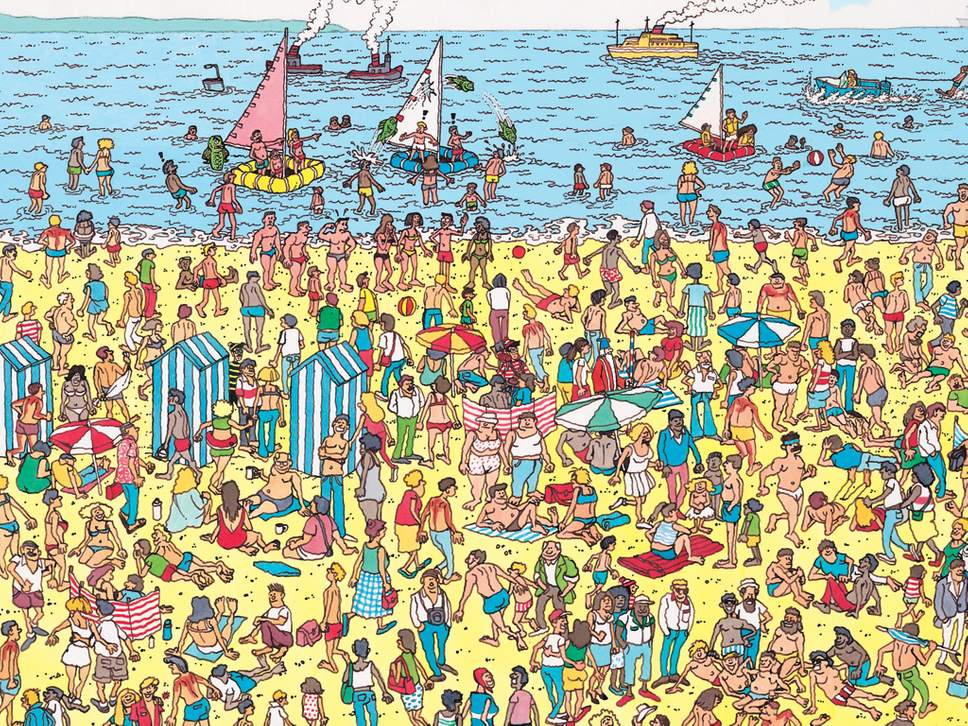

In [8]:
from IPython.display import Image
Image("../img/where-wally-walker-books.jpg")

 $V[i,j,a,b] = V[a,b]$.
As a result we can simplify the definition for $h$.

$$h[i,j] = \sum_{a, b} V[a,b] \cdot x[i+a,j+b]$$

This is a convolution!
We are effectively weighting pixels $(i+a, j+b)$
in the vicinity of $(i,j)$ with coefficients $V[a,b]$
to obtain the value $h[i,j]$.
Note that $V[a,b]$ needs many fewer coefficients than $V[i,j,a,b]$. For a 1 megapixel image it has at most 1 million coefficients. This reduces the number of parameters by a factor of 1 million since it no longer depends on the location within the image. We have made significant progress!

Now let's invoke the second principle - *locality*.
As motivated above, we believe that we shouldn't have
to look very far away from $(i,j)$
in order to glean relevant information
to assess what is going on at $h[i,j]$.
This means that outside some range $|a|, |b| > \Delta$,
we should set $V[a,b] = 0$.
Equivalently, we can rewrite $h[i,j]$ as

$$h[i,j] = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} V[a,b] \cdot x[i+a,j+b]$$

This, in a nutshell is the convolutional layer.
When the local region (also called a *receptive field*) is small,
the difference as compared to a fully-connected network can be dramatic.
While previously, we might have required billions of parameters
to represent just a single layer in an image-processing network,
we now typically need just a few hundred.
The price that we pay for this drastic modification
is that our features will be translation invariant
and that our layer can only take local information into account.
All learning depends on imposing inductive bias.
When that bias agrees with reality,
we get sample-efficient models
that generalize well to unseen data.
But of course, if those biases do not agree with reality,
e.g. if images turned out not to be translation invariant,



## Convolutions

Let's briefly review why the above operation is called a *convolution*.
In mathematics, the convolution between two functions,
say $f, g: \mathbb{R}^d \to \mathbb{R}$ is defined as

$$[f \circledast g](x) = \int_{\mathbb{R}^d} f(z) g(x-z) dz$$

That is, we measure the overlap between $f$ and $g$
when both functions are shifted by $x$ and 'flipped'.
Whenever we have discrete objects, the integral turns into a sum.
For instance, for vectors defined on $\ell_2$, i.e.,
the set of square summable infinite dimensional vectors
with index running over $\mathbb{Z}$ we obtain the following definition.

$$[f \circledast g](i) = \sum_a f(a) g(i-a)$$

For two-dimensional arrays, we have a corresponding sum
with indices $(i,j)$ for $f$ and $(i-a, j-b)$ for $g$ respectively.
This looks similar to definition above, with one major difference.
Rather than using $(i+a, j+b)$, we are using the difference instead.
Note, though, that this distinction is mostly cosmetic
since we can always match the notation by using $\tilde{V}[a,b] = V[-a, -b]$
to obtain $h = x \circledast \tilde{V}$.
Also note that the original definition is actually a *cross correlation*.
We will come back to this in the following section.

## Waldo Revisited

Let's see what this looks like if we want to build an improved Waldo detector. The convolutional layer picks windows of a given size
and weighs intensities according to the mask $V$.
 We expect that wherever the 'waldoness' is highest,
 we will also find a peak in the hidden layer activations.


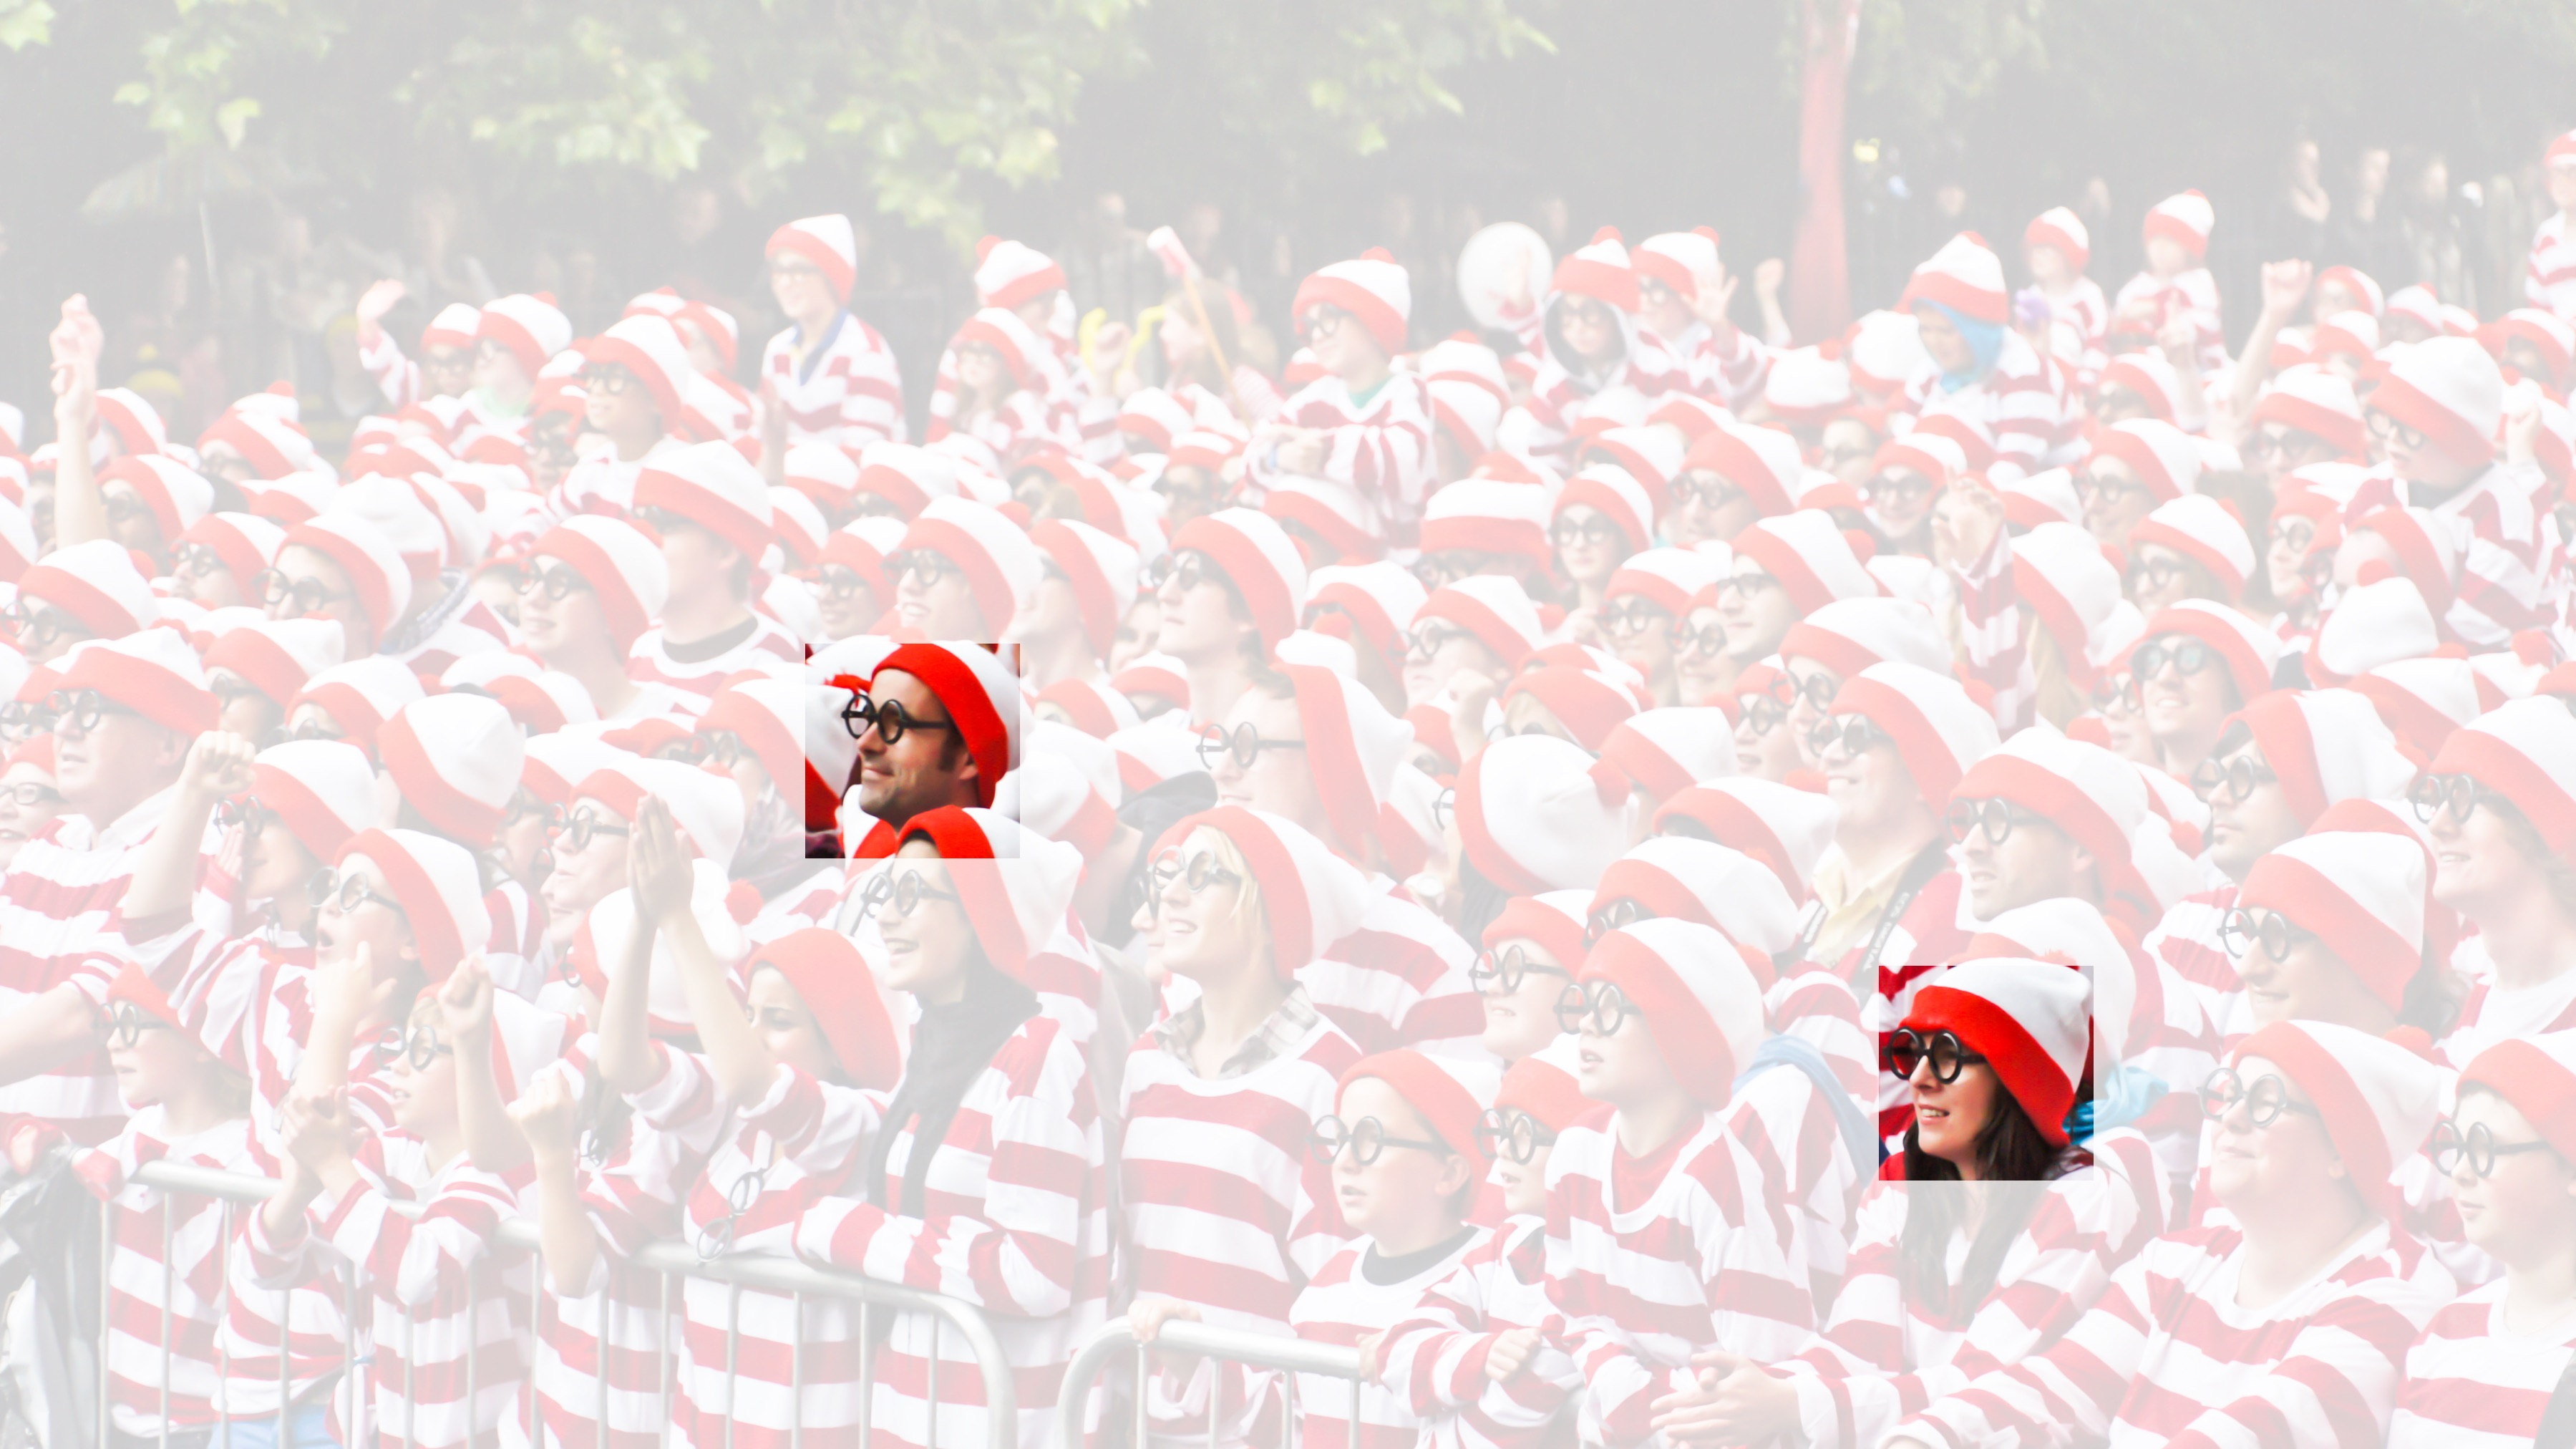

In [5]:
from IPython.display import Image
Image("../img/waldo-mask.jpg")

There's just a problem with this approach:
so far we blissfully ignored that images consist
of 3 channels: red, green and blue.
In reality, images are quite two-dimensional objects
but rather as a 3rd order tensor,
e.g., with shape $1024 \times 1024 \times 3$ pixels.
Only two of these axes concern spatial relationships,
while the 3rd can be regarded as assigning
a multidimensional representation *to each pixel location*.

We thus index $\mathbf{x}$ as $x[i,j,k]$.
The convolutional mask has to adapt accordingly.
Instead of $V[a,b]$ we now have $V[a,b,c]$.

Moreover, just as our input consists of a 3rd order tensor
it turns out to be a good idea to similarly formulate
our hidden representations as 3rd order tensors.
In other words, rather than just having a 1D representation
corresponding to each spatial location,
we want to have a multidimensional hidden representations
corresponding to each spatial location.
We could think of the hidden representation as comprising a number of 2D grids stacked on top of each other.
These are sometimes called *channels* or *feature maps*.
Intuitively you might imagine that at lower layers,
some channels specialize to recognizing edges,
We can take care of this by adding a fourth coordinate to $V$
via $V[a,b,c,d]$. Putting all together we have:

$$h[i,j,k] = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c V[a,b,c,k] \cdot x[i+a,j+b,c]$$

This is the definition of a convolutional neural network layer.
There are still many operations that we need to address.
For instance, we need to figure out how to combine all the activations
to a single output (e.g. whether there's a Waldo in the image).
We also need to decide how to compute things efficiently,
how to combine multiple layers, and whether it is a good idea
to have many narrow or a few wide layers.
All of this will be addressed in the remainder of the chapter.


## Summary

* Translation invariance in images implies that all patches of an image will be treated in the same manner.
* Locality means that only a small neighborhood of pixels will be used for computation.
* Channels on input and output allows for meaningful feature analysis.

## Exercises

1. Assume that the size of the convolution mask is $\Delta = 0$. Show that in this case the convolutional mask implements an MLP independently for each set of channels.
1. Why might translation invariance not be a good idea after all? Does it make sense for pigs to fly?
1. What happens at the boundary of an image?
1. Derive an analogous convolutional layer for audio.
1. What goes wrong when you apply the above reasoning to text? Hint - what is the structure of language?
1. Prove that $f \circledast g = g \circledast f$